In [28]:
import os

import sys
sys.path.insert(0, '../gofher')

from run_gofher_on_a_galaxy import run_panstarrs
from matrix import create_dist_matrix, create_centered_mesh_grid, create_minor_axis_angle_matrix
from spin_parity import read_spin_parity_galaxies_label_from_csv
#from galaxy import pos_neg_label_from_theta

import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

In [29]:
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rc('font', family='Nimbus Roman No9 L')

In [30]:
path_to_input = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog-data\\panstarrs"
output_path_for_gradient_trend = "E:\\grad_school\\research\\spin_parity_panstarrs\\paper_writing\\figure_maker\\{}_test_test_diff_trend.png"

In [31]:
def get_galaxy_list(folder_name):
    """the list of galaxy names to run on"""
    return os.listdir(os.path.join(path_to_input,folder_name))

In [32]:
#def get_fits_path(name,band,):
#    """the file path of where existing fits files can be found"""
#    return os.path.join(path_to_input,folder_name,name,"{}_{}.fits".format(name,band))
#def get


def get_dark_side_csv_path(folder_name):
    csv_path = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog-data\\catalog"
    return os.path.join(csv_path,"{}.csv".format(folder_name))

def get_color_image_path(name,folder_name):
    return os.path.join(path_to_input,folder_name,name,"{}_color.jfif".format(name))

In [33]:
def seperate_out_for_gradient(the_gal, poly_degree, max_ang_from_minor,linspace=100):
    x = the_gal.gofher_params.x; y = the_gal.gofher_params.x
    theta = the_gal.gofher_params.theta
    shape = the_gal[the_gal.ref_band].data.shape

    xv,yv = create_centered_mesh_grid(x,y,shape)
    dist = create_dist_matrix(xv,yv)
    ang = np.abs(create_minor_axis_angle_matrix(x,y,theta,shape))
    #ang[ang > max_ang_from_minor] = 0.0

    el_mask = the_gal.create_ellipse()
    pos_mask, neg_mask = the_gal.create_bisection()

    to_include = np.logical_and(el_mask,ang < max_ang_from_minor)
    b = the_gal.gofher_params.b

    
    to_return = dict()

    for band_pair_key in the_gal.band_pairs:
        band_pair = the_gal.get_band_pair(band_pair_key)
        diff_image = band_pair.diff_image
        diff_image[np.logical_not(to_include)] = -np.Inf

        ones = np.ones(shape)
        if band_pair.paper_classification == 1: #use band_pair.paper_classification for author provided dark side labels
            ones[neg_mask] *= -1
        elif band_pair.paper_classification == -1: #use band_pair.paper_classification for author provided dark side labels
            ones[pos_mask] *= -1
        else:
            return None

        
        xs = ((ones*dist)/b)[np.logical_not(np.isinf(diff_image))]
        ys = diff_image[np.logical_not(np.isinf(diff_image))]
        
        the_min = np.min(diff_image[np.logical_not(np.isinf(diff_image))])
        the_max = np.max(diff_image[np.logical_not(np.isinf(diff_image))])
        ys_normed = (ys-the_min)/(the_max-the_min)
        #print(the_min,the_max)
        #plt.imshow((ones*dist)/b,origin='lower')
        #plt.show()
        """
        plt.scatter(xs,ys)
        plt.plot(*np.polynomial.Polynomial.fit(xs, ys, poly_degree).linspace(linspace), 'r-')
        plt.show()

        plt.scatter(xs,ys_to_plot)
        plt.plot(*np.polynomial.Polynomial.fit(xs, ys_normed, poly_degree).linspace(linspace), 'r-')
        plt.show()
        """
        #break
        to_return[band_pair_key] = np.polynomial.Polynomial.fit(xs, ys_normed, poly_degree).linspace(linspace)

        print(band_pair_key)
        plt.scatter(xs,ys_normed,alpha=0.5,color='blue')
        plt.plot(*to_return[band_pair_key],color='red')
        plt.show()
    return to_return

def plot_all_trends(all_trends,output_path, poly_degree, linspace=100):
    keys = [['r-i', 'r-z'],
            ['r-y','i-z'],
            ['i-y','z-y']]
    first_fig = ['a','b','c','d','e','f']
    count = 0
    fig, axd = plt.subplot_mosaic(keys,figsize=(10/3, 4),
                                  constrained_layout=True,num=1, clear=True) #num=1, clear=True #https://stackoverflow.com/a/65910539/13544635
    fig.patch.set_facecolor('white')
    for band_pair in all_trends:
        xs = []
        ys = []
        for each in all_trends[band_pair]:
            x = each[0]
            y = each[1]
            mask = np.logical_and(x>-1.0,x<1.0)
            xs.extend(list(x[mask]))
            ys.extend(list(y[mask]))
            axd[band_pair].plot(x,y, alpha=0.25,linewidth=1.0,c='blue')

        aggregate_trend = np.polynomial.Polynomial.fit(xs, ys, poly_degree).linspace(linspace)
        axd[band_pair].plot(*aggregate_trend,linewidth=1.0,c='red', ls='--')

        axd[band_pair].axvline(0.0,c='black')

        
        i = np.argmin(aggregate_trend[1])
        min_x = aggregate_trend[0][i]
        axd[band_pair].axvline(min_x,c='red',linewidth=1.0)
        #axd[band_pair].legend()
        
        the_title = "({}) {}:".format(first_fig[count],band_pair)
        axd[band_pair].set_title(the_title)
        axd[band_pair].set_ylabel("||Difference||")
        axd[band_pair].set_xlabel("||Distance||")
        
        axd[band_pair].set_xlim([-1, 1])
        axd[band_pair].set_ylim([0, 1])
        count += 1
    #plt.show()
    fig.savefig(output_path, dpi=300)


In [34]:
def run_on_folder_name(folder_name):
    dark_side_labels = read_spin_parity_galaxies_label_from_csv(get_dark_side_csv_path(folder_name))
    if folder_name == "table2" and "IC 2101" in dark_side_labels:
        dark_side_labels["IC2101"] = dark_side_labels["IC 2101"]
    #correcting erroneous dark side labels per psin parity authors:
    if "NGC1" in dark_side_labels:
        print("correcting dark side label of {} from {} to {} (per Spin Parity Catalog authors)".format("NGC1",dark_side_labels["NGC1"],"sw"))
        dark_side_labels["NGC1"] = "sw"
    if "NGC4536" in dark_side_labels:
        print("correcting dark side label of {} from {} to {} (per Spin Parity Catalog authors)".format("NGC4536",dark_side_labels["NGC4536"],"ne"))
        dark_side_labels["NGC4536"] = "ne"
    if "NGC1385" in dark_side_labels:
        print("correcting dark side label of {} from {} to {} (per Spin Parity Catalog authors)".format("NGC1385",dark_side_labels["NGC1385"],"W"))
        dark_side_labels["NGC1385"] = "W"
    if "NGC3887" in dark_side_labels:
        print("correcting dark side label of {} from {} to {} (per Spin Parity Catalog authors)".format("NGC3887",dark_side_labels["NGC3887"],"W"))
        dark_side_labels["NGC3887"] = "W"

    all_trends = defaultdict(list)

    i=1
    for name in get_galaxy_list(folder_name):
        print(i,name)
        if name not in dark_side_labels: continue

        get_fits_path = lambda name,band: os.path.join(path_to_input,folder_name,name,"{}_{}.fits".format(name,band))

        try:
            the_gal = run_panstarrs(name,get_fits_path,'', dark_side_label=dark_side_labels[name], color_image_path=get_color_image_path(name,folder_name))
            gal_trend_lines = seperate_out_for_gradient(the_gal,10,math.pi/4)
            
            if isinstance(gal_trend_lines,type(None)):
                print("skipping")
                continue
            to_include = True
            for each_band_pair in gal_trend_lines:
                x = gal_trend_lines[each_band_pair][0]
                y = gal_trend_lines[each_band_pair][1]
                if np.max(x) > 2.0 or np.min(x) < -2.0 or np.max(y) > 1.001 or np.min(y) < -0.0001:
                    to_include = False
                    break

            if not to_include:
                print("skipping")
                continue

            for each_band_pair in gal_trend_lines:
                all_trends[each_band_pair].append(gal_trend_lines[each_band_pair])

        except Exception as e:
            print("Exception on gal",name,e)
        break
        i += 1
        #if i > 1: break
    return all_trends


figure8
1 IC 2101
1 IC1683
r-i


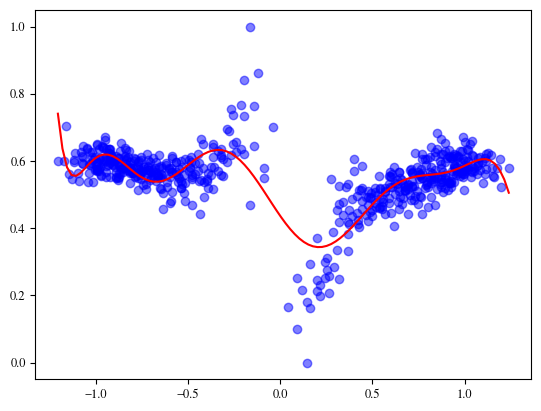

r-z


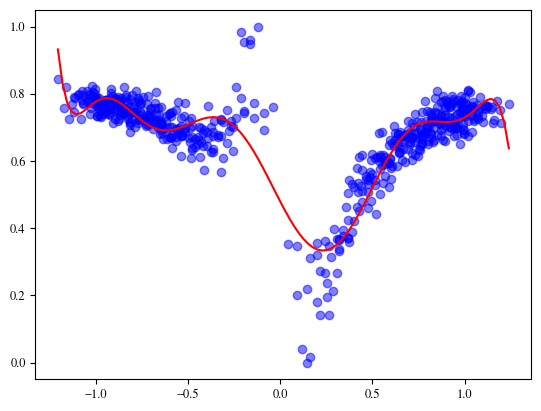

r-y


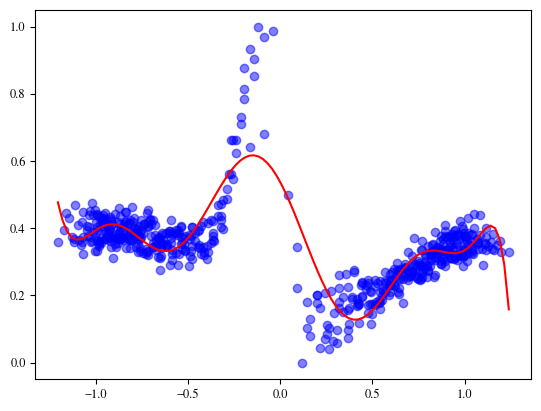

i-z


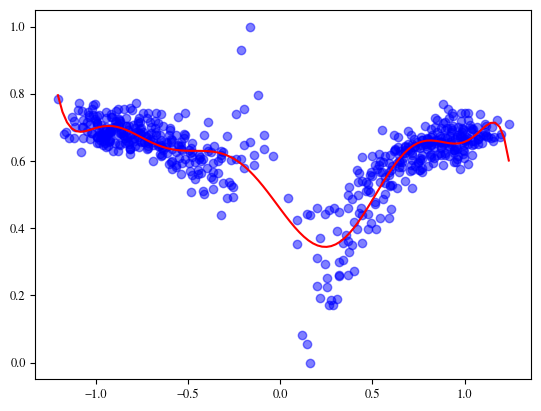

i-y


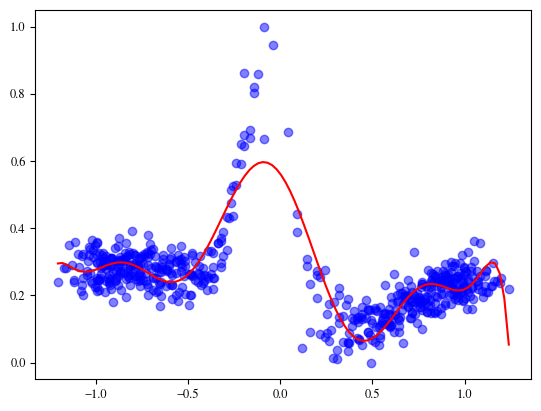

z-y


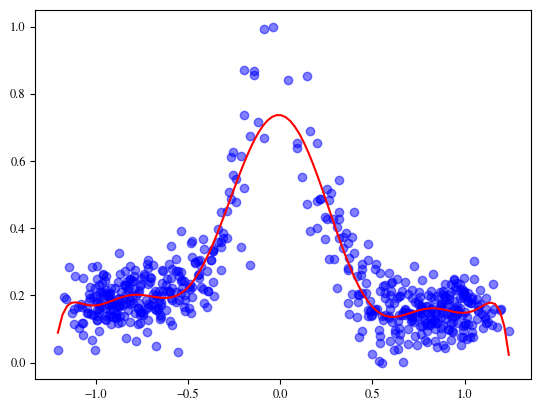

In [35]:
all_trends = defaultdict(list)

dtk = "observed"
#dtk = "inferred"

for folder_name in ["figure8","figure10","figure11"]:
#for folder_name in ["figure9"]:
    print(folder_name)
    returned = run_on_folder_name(folder_name)
    for each_key in returned:
        all_trends[each_key].extend(returned[each_key])
    break
##plot_all_trends(all_trends,output_path_for_gradient_trend.format(dtk),10,100)

In [36]:
k = list(all_trends.keys())[0]
print(len(all_trends[k]))

1
